In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import os

### Get geometries.

This accesses my own database, so unfortunately, you will have to download these yourselves.  You probably want the Census' Cartographic Boundary (CB) shapefiles for tracts and places, potentially along with ones for commuting areas or core-based statistical areas.

https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html

In [2]:
cen_con = get_con()

In [3]:
cities = list(pd.read_sql("SELECT name FROM census_place_2018 WHERE top20;", cen_con).name)

city_tracts_sql = """
SELECT pl.state, pl.name, tr18.geoid, tr18.geom geom
FROM   census_tracts_2018 tr18, census_place_2018 pl
WHERE 
  pl.state = tr18.state AND pl.top20 AND
  ST_Intersects(tr18.geom, pl.geom) AND
  ST_Area(ST_Intersection(tr18.geom, pl.geom)) > ST_Area(tr18.geom) / 2;
"""

geo_tracts = gpd.read_postgis(city_tracts_sql, con = cen_con, 
                              index_col = "geoid", geom_col = "geom", crs = "EPSG:2163")

city_tracts = geo_tracts.name.to_dict()

### FCC Notes

* See the `get_fcc.py` script for processing.
* Contractually obligated numbers usually not filled in -- e.g., never non-zero for Comcast.
* Careful that tracts do change between 2018 and 2019.  Fixing the only real problem for 2010 to 2018 in cities: 
  * There are two mismatched tracts -- one in NYC and the other in LA -- weird cases of changes on the edge of the cities.  LA was a contorted boundary of an old tract by Calabasas.  In NYC it's like a "landing" tract in Staten Island that we can drop).
  * SQL below does the check in my own DB.
  
```
SELECT tr10.geoid tr10
FROM census_tracts_2010 tr10
LEFT JOIN census_tracts_2018 tr18 ON 
  tr10.state = tr18.state AND 
  tr10.county = tr18.county AND 
  tr10.tract = tr18.tract 
JOIN census_place_2018 pl ON 
  ST_Intersects(tr10.geom, pl.geom) AND
  pl.top20
WHERE 
  tr18.geoid IS NULL;
```

In [4]:
fcc = pd.read_csv("../data/fcc_tract.csv.gz")

#  The only city tract
fcc.replace({"geoid" : {6037930401 : 6037137000}}, inplace = True)

### ACS
See the `get_acs.py` script for processing / retrieval.

In [5]:
acs = pd.read_csv("../data/acs_2019.csv.gz")

acs.drop(["state", "county", "tract"], inplace = True, axis = 1)
acs["city"] = acs.geoid.replace(city_tracts)
acs.loc[~acs.geoid.isin(city_tracts), "city"] = np.nan

Construct variables.

In [6]:
acs["nhh_no_broadband"]                     = acs["households"] - acs["nhh_broadband"]
acs["n_children_no_computer_and_broadband"] = acs["n_children"] - acs["n_children_computer_and_broadband"]

acs["f_children_computer_and_broadband"] \
  = (acs["n_children_computer_and_broadband"] / acs["n_children"]).round(3)

for v in ["f_broadband", "f_computer", "f_ba", "f_black", "f_hispanic"]:
    acs.loc[acs[v] < 0, v] = np.nan

In [8]:
acs["raw_ba"] = acs["n_ba"] / acs["den_ba"]

### Merge them...

In [9]:
acs_fcc = pd.merge(acs, fcc).set_index("geoid")
acs_fcc_geo = geo_tracts.join(acs_fcc)

### Plot Chicago

In [10]:
chicago = acs_fcc_geo.query("name == 'Chicago'").dropna().to_crs(epsg = 3528)

In [11]:
style_kws = {"cmap" : "Blues", "linewidth" : 0.1, "edgecolor" : "k", "legend" : True}

mpl.rcParams['hatch.linewidth'] = 0.1
na_style_kws = {"alpha" : 1, "edgecolor" : "k", "legend" : False,
                "hatch" : "//////////", "color" : "w", "linewidth" : 0.1}

/home/jsaxon/.anaconda/envs/geo/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/jsaxon/.anaconda/envs/geo/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/jsaxon/.anaconda/envs/geo/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/jsaxon/.anaconda/envs/geo/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


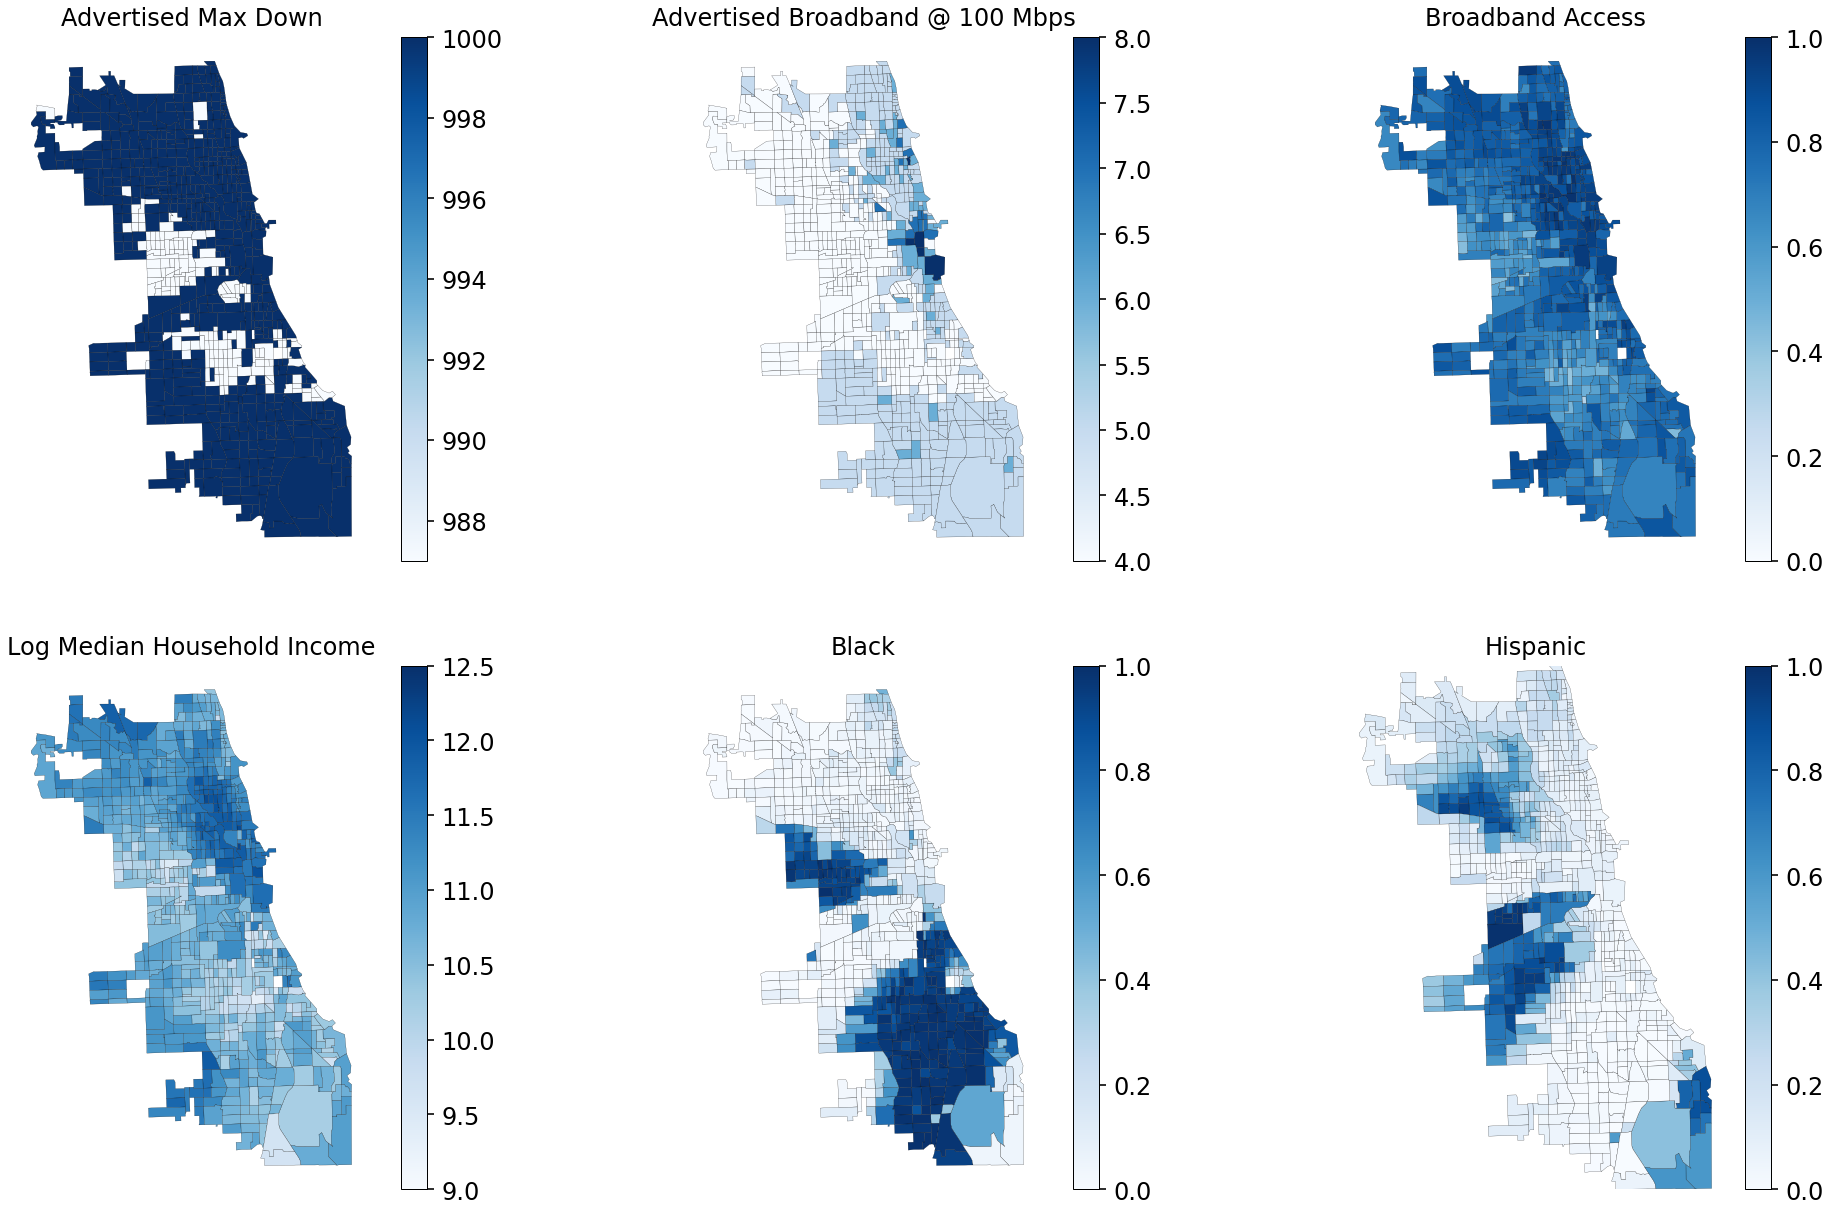

In [12]:
fig, ax = plt.subplots(2, 3, figsize = (14, 8))

for axi in ax.flatten(): map_format(axi)

ax[0][0].set_title("Advertised Max Down")
chicago.plot(column = "maxdowna", **style_kws, ax = ax[0][0])

ax[0][1].set_title("Advertised Broadband @ 100 Mbps")
chicago.plot(column = "n100a", vmax = 8, **style_kws, ax = ax[0][1])

ax[0][2].set_title("Broadband Access")
chicago.plot(column = "f_broadband", vmin = 0, vmax = 1, **style_kws, ax = ax[0][2])
chicago[chicago["f_broadband"] < 0].plot(**na_style_kws, ax = ax[0][2])

ax[1][0].set_title("Log Median Household Income")
chicago.plot(column = "log_mhi", vmin = 9, vmax = 12.5, **style_kws, ax = ax[1][0])
chicago[chicago["log_mhi"].isna()].plot(**na_style_kws, ax = ax[1][0])

ax[1][1].set_title("Black")
chicago.plot(column = "f_black", vmin = 0, vmax = 1, **style_kws, ax = ax[1][1])
chicago[chicago["f_black"] < 0].plot(**na_style_kws, ax = ax[1][1])

ax[1][2].set_title("Hispanic")
chicago.plot(column = "f_hispanic", vmin = 0, vmax = 1, **style_kws, ax = ax[1][2])
chicago[chicago["f_hispanic"] < 0].plot(**na_style_kws, ax = ax[1][2])

plt.subplots_adjust(hspace = 0.20)

fig.savefig("../figs/fcc_maps.pdf")
fig.savefig("../figs/fcc_maps.png", bbox_inches = "tight", pad_inches = 0.1, dpi = 300)

Text(0.6, 1.08, 'Broadband Access on the South Side')

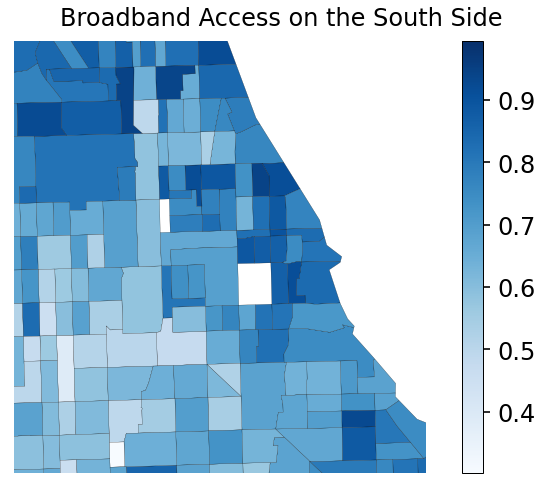

In [13]:
ax = chicago.plot(column = "f_broadband", **style_kws, figsize = (5, 3))

# streets = gpd.read_file("streets_lw.geojson")
# streets.plot(color = "w", lw = streets.highway_thickness / 10, ax = ax)

map_format(ax)
ax.set_xlim(355000, 365000)
ax.set_ylim(564500, 575000)

ax.figure.suptitle("Broadband Access on the South Side", x = 0.6, y = 1.08)

### Now let's investigate a bit...

In [14]:
chicago[["log_mhi", "f_ba", "f_black", "f_hispanic", "f_broadband", "nisp", "n25a", "n100a", "maxdowna"]]\
    .corr().abs().round(3).style.background_gradient(cmap='viridis')

,log_mhi,f_ba,f_black,f_hispanic,f_broadband,nisp,n25a,n100a,maxdowna
log_mhi,1.000000,0.756000,0.652000,0.004000,0.796000,0.320000,0.306000,0.306000,0.442000
f_ba,0.756000,1.000000,0.471000,0.358000,0.734000,0.461000,0.447000,0.447000,0.346000
f_black,0.652000,0.471000,1.000000,0.535000,0.570000,0.093000,0.079000,0.079000,0.286000
f_hispanic,0.004000,0.358000,0.535000,1.000000,0.044000,0.278000,0.279000,0.279000,0.013000
f_broadband,0.796000,0.734000,0.570000,0.044000,1.000000,0.307000,0.302000,0.302000,0.391000
nisp,0.320000,0.461000,0.093000,0.278000,0.307000,1.000000,0.962000,0.962000,0.365000
n25a,0.306000,0.447000,0.079000,0.279000,0.302000,0.962000,1.000000,1.000000,0.385000
n100a,0.306000,0.447000,0.079000,0.279000,0.302000,0.962000,1.000000,1.000000,0.385000
maxdowna,0.442000,0.346000,0.286000,0.013000,0.391000,0.365000,0.385000,0.385000,1.000000


In [15]:
chicago.corr().abs().f_broadband.sort_values(ascending = False)[1:].round(3)

f_broadband                             1.000
computer                                0.878
f_computer                              0.878
log_mhi                                 0.796
mhi.1                                   0.741
mhi                                     0.741
ba                                      0.734
f_ba                                    0.734
raw_ba                                  0.734
f_children_computer_and_broadband       0.654
black                                   0.570
f_black                                 0.570
nhh_no_computer                         0.544
n_children_no_computer_and_broadband    0.504
n_ba                                    0.501
nhh_no_broadband                        0.492
n_children_computer_no_internet         0.444
nhh_computer_and_broadband              0.401
n_black                                 0.399
n_broadband                             0.396
nhh_broadband                           0.396
maxdowna                          

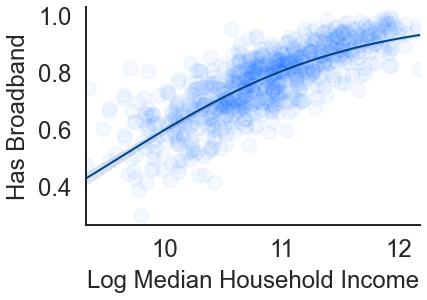

In [16]:
import seaborn as sns
sns.set_style("white")

import matplotlib as mpl
mpl.rcParams["axes.linewidth"] = 1

fig, ax = plt.subplots(figsize = (3, 2))

sns.regplot(data = chicago, x = "log_mhi", y = "f_broadband", 
            scatter_kws = {"alpha" : 0.04, "s" : 50, "color" : "#0066FF"}, 
            line_kws    = {"lw" : 1, "color" : "#004488"}, 
            logistic = True, ax = ax)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlabel("Log Median Household Income")
ax.set_ylabel("Has Broadband")

fig.savefig("../figs/broadband_income.pdf")

In [17]:
import statsmodels.formula.api as smf

from statsmodels.discrete.discrete_model import Logit as logit, Probit as probit

In [18]:
chicago["C"] = 1  ## Add a constant

In [19]:
exog = ["log_mhi", "nisp", "n25a", "f_ba", "f_black", "f_hispanic", "C"]
logit(chicago.f_broadband, chicago[exog]).fit().summary()    

Optimization terminated successfully.
         Current function value: 0.404144
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            f_broadband   No. Observations:                  792
Model:                          Logit   Df Residuals:                      785
Method:                           MLE   Df Model:                            6
Date:                Fri, 19 Feb 2021   Pseudo R-squ.:                  -5.142
Time:                        13:02:25   Log-Likelihood:                -320.08
converged:                       True   LL-Null:                       -52.112
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_mhi        0.6106      0.270      2.263      0.024       0.082       1.139
nisp          -0.0890      0.459     -0.194      0.846      -0.989       0.811
n25a           0.0945      0.489      0.193      0.847      -0.864       1.053
f_ba           1.2960      0.799      1.621      0.105      -0.271       2.863
f_black       -0.0226      0.502     -0.045      0.964      -1.006       0.961
f_hispanic     0.1368      0.621      0.220      0.826      -1.081       1.355
C             -5.7559      2.944     -1.955      0.051     -11.526       0.015
==============================================================================
"""

In [20]:
for name, exog in {"MHI"  : ["log_mhi", "C"],
                   "ACS"  : ["log_mhi", "f_ba", "f_black", "f_hispanic", "C"],
                   "Race" : ["f_black", "f_hispanic", "C"],
                   "FCC"  : ["nisp", "n25a", "C"],
                   "All"  : ["nisp", "n25a", "log_mhi", "f_ba", "f_black", "f_hispanic", "C"],
                  }.items():

    lfit = logit(chicago.f_broadband, chicago[exog]).fit()
    chicago["pred" + name] = lfit.predict(chicago[exog])
    
print("\n ** CORRELATIONS FOR PREDICTED LOGIT MODELS **")
chicago.corr().f_broadband.abs().sort_values(ascending = False).filter(regex = "pred", axis = 0)

Optimization terminated successfully.
         Current function value: 0.405949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404144
         Iterations 6

 ** CORRELATIONS FOR PREDICTED LOGIT MODELS **


predAll     0.834393
predACS     0.833954
predMHI     0.789141
predRace    0.706800
predFCC     0.313332
Name: f_broadband, dtype: float64

So basically, it looks like this "saturates" on money.  Having 25 Mbps just depends on log household income.

Note that this is pretty different from what they did in the ML lab, where the outcome was whether or not broadband was contractually available.  In the case of the BDT / forest, nISP is particularly well suited, since it aligns with the geography of the contractual availability (suppliers generally offer broadband within their service territory).  That means that you have a binary choice that cleanly cuts broadband / no broadband.  Again, note the contractual availability is probably not the right metric.

### Save these in geojson files, for plotting / map.

In [22]:
for c in cities:
    cl = c.replace(" ", "_").lower()
    city_geo = acs_fcc_geo.query("name == '{}'".format(c)).to_crs(epsg = 4326)
    
    os.remove("../site/tracts/{}.geojson".format(cl))
    city_geo[["f_broadband", "f_computer", "nhh_no_computer", "nhh_no_broadband",
              'f_children_computer_and_broadband', 
              'n_children_no_computer', 
              'n_children_no_computer_and_broadband',
              "f_ba", "log_mhi", "f_black", "f_hispanic", 
              "n100a", "n25a", "maxdowna", "geom"]]\
      .to_file("../site/tracts/{}.geojson".format(cl), driver = "GeoJSON")

In [28]:
f_vars = ["f_broadband", "f_computer", "nhh_no_computer", "nhh_no_broadband",
          'f_children_computer_and_broadband', 
          'n_children_no_computer', 
          'n_children_no_computer_and_broadband',
          "f_ba", "log_mhi", "f_black", "f_hispanic", 
          "n100a", "n25a", "maxdowna", "geom"]

counts = ["population", "households", "den_computers", "n_children", 
          "n_computer", "n_broadband", "n_children_computer_and_broadband", 
          "den_black", "n_black", "den_hispanic", "n_hispanic", "den_ba", "n_ba"]

o_vars = set(f_vars + counts)

c = "Chicago"
cl = c.replace(" ", "_").lower()
city_geo = acs_fcc_geo.query("name == '{}'".format(c)).to_crs(epsg = 4326)

# os.remove("../data/{}.geojson".format(cl))
city_geo[o_vars].to_file("../data/{}_tracts.geojson".format(cl), driver = "GeoJSON")